In [2]:
import glob
import pickle
import os
import torch

import anndata as ad
import h5py
import scanpy as sc
from scipy.sparse import csr_matrix
from sklearn import model_selection
import yaml

from src.da_utils.data_processing import qc_sc
from src.da_utils import data_loading
from src.da_utils.data_loading import load_spatial, get_selected_dir, get_dset_dir

import pandas as pd
import numpy as np

import seaborn as sns
import pickle

import matplotlib.pyplot as plt


In [4]:
adata_st = sc.read_h5ad("data/dlpfc/preprocessed/GSE144136_spatialLIBD/20markers/minmax/mat_sp_samp_split_d.h5ad")
adata_st

AnnData object with n_obs × n_vars = 47681 × 360
    obs: 'split', 'sample_id', 'X', 'Y', 'index', 'key', 'subject', 'replicate', 'Cluster', 'sum_umi', 'sum_gene', 'cell_count', 'in_tissue', 'spatialLIBD', 'array_col', 'array_row'

In [8]:
adata_st.obs.index.to_numpy() #.to_numpy()

array(['AAACAACGAATAGTTC-1', 'AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1',
       ..., 'TTGTTTCATTAGTCTA-1-10', 'TTGTTTCCATACAACT-1-10',
       'TTGTTTGTATTACACG-1-6'], dtype=object)

In [21]:
adata_st.obs["split"].value_counts()

train    40450
val       3639
test      3592
Name: split, dtype: int64

In [3]:
RCTD_DATA_DIR = "/mnt/c/Users/mawil/Documents/McGill/research/chijimatsu2022_pdac/preprocessed_data"
DSETS = ("dlpfc", "spotless", "pdac")

In [10]:
sc_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, DSETS[0], f"all/raw_counts/sc_train.h5ad"))

In [13]:

with h5py.File(os.path.join(RCTD_DATA_DIR, DSETS[0], "all/raw_counts/sc_train.h5"), 'w') as f:
    dt = h5py.string_dtype(encoding='utf-8')

    ds = f.create_dataset('colNames', dtype=dt, data=sc_ad.var.index.to_numpy())
    ds = f.create_dataset('rowNames', dtype=dt, data=sc_ad.obs.index.to_numpy())

In [14]:
with h5py.File(os.path.join(RCTD_DATA_DIR, DSETS[0], "all/raw_counts/sc_train.h5"), 'r') as f:
    dt = h5py.string_dtype(encoding='utf-8')

    colNames = f["colNames"][()]
    rowNames = f["rowNames"][()]

print(colNames)
print(rowNames)

[b'TSPAN6' b'TNMD' b'DPM1' ... b'AC016831.7' b'AC004593.3' b'ZNF883']
[b'Ex_1_L5_6.7_Control_B5_CAAGGCCAGAATTCCC'
 b'Ex_8_L5_6.20_Control_B4_GTGAAGGAGGTGATTA'
 b'Oligos_3.31_Control_B5_CTGCCTAAGATATACG' ...
 b'OPCs_2.13_Control_B3_TACCTTAAGCGCCTTG'
 b'Ex_3_L4_5.13_Control_B3_ACCAGTAGTCATACTG'
 b'Ex_8_L5_6.13_Control_B3_GTGCTTCTCGCCAGCA']


In [4]:
for dset in DSETS:
    print(dset)

    print("sc")
    sc_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, dset, f"all/raw_counts/sc_train.h5ad"))
    sc_ad.obs.index = sc_ad.obs.index.str.replace("/", "Slash")
    sc_ad.obs.index = sc_ad.obs.index.set_names("x")
    sc_ct = sc_ad.obs["cell_type"]
    sc_ct = sc_ct.str.replace("/", "Slash")    

    keep_cell_types = set(sc_ct.value_counts()[sc_ct.value_counts() >= 25].index.tolist())
    sc_ct = sc_ct[sc_ct.isin(keep_cell_types)]
    sc_ad = sc_ad[sc_ct.index, :]
    
    
    # sc_ct.to_csv(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/sc_train_cell_type.csv"))
    with h5py.File(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/sc_train.h5"), "w") as f:
        h5_string = h5py.string_dtype(encoding='utf-8')
        f.create_dataset("X", data=sc_ad.to_df().to_numpy().astype(np.int32))
        f.create_dataset("cell_type", dtype=h5_string, data=sc_ct.to_numpy())
        f.create_dataset("genes", dtype=h5_string, data=sc_ad.var.index.to_numpy())
        f.create_dataset("samples", dtype=h5_string, data=sc_ad.obs.index.to_numpy())

    sc_ad.obs.to_csv(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/sc_obs.csv"))

    print("st")
    if dset == "pdac":
        st_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/unscaled/mat_sp_train_d.h5ad"))
    else:
        st_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/unscaled/mat_sp_samp_split_d.h5ad"))
    st_ad.obs.index = st_ad.obs.index.str.replace("-", ".")
    st_ad.obs.index = st_ad.obs.index.set_names("spot")


    with h5py.File(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/unscaled/st_train.h5"), "w") as f:
        h5_string = h5py.string_dtype(encoding='utf-8')

        f.create_dataset("X", data=st_ad.to_df().to_numpy().astype(np.int32))
        f.create_dataset("coords", data=st_ad.obs[["X", "Y"]].to_numpy().astype(np.float32))
        f.create_dataset("genes", dtype=h5_string, data=st_ad.var.index.to_numpy())
        f.create_dataset("samples", dtype=h5_string, data=st_ad.obs.index.to_numpy())

    st_ad.obs.to_csv(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/unscaled/st_obs.csv"))
    # st_ad.obs[["X", "Y"]].to_csv(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/unscaled/st_XY.csv"))
    # st_ad.to_df().T.to_csv(os.path.join(RCTD_DATA_DIR, dset, "all/raw_counts/unscaled/st_gex.csv"))

    



dlpfc
sc
st
spotless
sc
st
pdac
sc
st


In [18]:
sc_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, "dlpfc", f"all/raw_counts/sc_train.h5ad"))

In [21]:
sc_ad.to_df().T.to_numpy().astype(np.int32).shape

(17927, 28169)

In [5]:
sc_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, DSETS[1], f"all/raw_counts/sc_train.h5ad"))
sc_ad.obs

,title,source_name,organism,donor_id,donor_sex,donor_genotype,injection_type,injection_target,injected_material,dissected_region,...,SRA_Run,GEO_Sample,GEO_Sample_Title,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_type,lab_sc_num
F2S4_160721_002_D01,F2S4_160721_002_D01,Anterior Lateral Motor Cortex (ALM),Mus musculus,258622,F,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,ALM,...,SRR7318501,GSM3189881,ALM_Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt_No In...,9533,9533,1770360.0,0.0,0.0,Lamp5,15
F2S4_161014_001_E01,F2S4_161014_001_E01,Anterior Lateral Motor Cortex (ALM),Mus musculus,274988,M,Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,ALM,...,SRR7312680,GSM3189851,ALM_Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt_No Inje...,4619,4619,1674653.0,0.0,0.0,Endo,6
F2S4_160818_007_G01,F2S4_160818_007_G01,Primary Visual Cortex (VISp),Mus musculus,264196,F,Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,SRR7331467,GSM3189947,VISp_Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt_No Injec...,10326,10326,1724552.0,0.0,0.0,L5 IT,10
F2S4_160706_058_G01,F2S4_160706_058_G01,Anterior Lateral Motor Cortex (ALM),Mus musculus,255319,F,Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,ALM,...,SRR7315506,GSM3189868,ALM_Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt_No Inject...,10027,10027,1629529.0,0.0,0.0,L5 IT,10
F2S4_160330_006_B01,F2S4_160330_006_B01,Primary Visual Cortex (VISp),Mus musculus,237303,M,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,SRR7336980,GSM3189967,VISp_Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt_No I...,9822,9822,2183614.0,0.0,0.0,L6 CT,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F2S4_160819_001_A01,F2S4_160819_001_A01,Anterior Lateral Motor Cortex (ALM),Mus musculus,264921,M,Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,ALM,...,SRR7313660,GSM3189855,ALM_Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt_No Injec...,8296,8296,1799372.0,0.0,0.0,Lamp5,15
F2S4_160706_035_A01,F2S4_160706_035_A01,Primary Visual Cortex (VISp),Mus musculus,254570,F,Slc17a7-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,SRR7333235,GSM3189956,VISp_Slc17a7-IRES2-Cre/wt;Ai14(RCL-tdT)/wt_No ...,10992,10992,1945612.0,0.0,0.0,L6 IT,13
F2S4_160309_004_A01,F2S4_160309_004_A01,Anterior Lateral Motor Cortex (ALM),Mus musculus,233911,M,Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,ALM,...,SRR7320498,GSM3189890,ALM_Tlx3-Cre_PL56/wt;Ai14(RCL-tdT)/wt_No Injec...,12725,12725,1727178.0,0.0,0.0,L5 IT,10
F2S4_170711_002_D01,F2S4_170711_002_D01,Anterior Lateral Motor Cortex (ALM),Mus musculus,332660,M,Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,ALM,...,SRR7312832,GSM3189851,ALM_Ctgf-T2A-dgCre/wt;Ai14(RCL-tdT)/wt_No Inje...,9402,9402,1802116.0,0.0,0.0,L6b,14


In [8]:
st_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, DSETS[1], "all/raw_counts/unscaled/mat_sp_samp_split_d.h5ad"))
st_ad.obs

,split,sample_id,X,Y,nCount_RNA,nFeature_RNA,orig.ident
spot_1,train,Eng2019_cortex_svz_fov0,466.019417,466.019417,82549.0,9871,0
spot_2,train,Eng2019_cortex_svz_fov0,466.019417,1000.000000,47199.0,9335,0
spot_3,train,Eng2019_cortex_svz_fov0,466.019417,1533.980583,15919.0,6288,0
spot_4,train,Eng2019_cortex_svz_fov0,1000.000000,466.019417,32359.0,8474,0
spot_5,train,Eng2019_cortex_svz_fov0,1000.000000,1000.000000,61491.0,9653,0
...,...,...,...,...,...,...,...
spot_5-3,test,Eng2019_cortex_svz_fov3,1000.000000,1000.000000,65475.0,9692,0
spot_6-3,test,Eng2019_cortex_svz_fov3,1000.000000,1533.980583,70453.0,9751,0
spot_7-3,test,Eng2019_cortex_svz_fov3,1533.980583,466.019417,66380.0,9784,0
spot_8-3,test,Eng2019_cortex_svz_fov3,1533.980583,1000.000000,52182.0,9561,0


In [29]:
sc_ad.obs["cell_type"][sc_ad.obs.cell_type == "Micro/Macro"]

x
Micro/Macro.15_Control_B4_CATTCGCAGACTACAA    Micro/Macro
Micro/Macro.12_Control_B3_ACCCACTGTGTCCTCT    Micro/Macro
Micro/Macro.16_Control_B6_TCTGAGAAGGACACCA    Micro/Macro
Micro/Macro.20_Control_B4_GTCAAGTCAAACTGTC    Micro/Macro
Micro/Macro.20_Control_B4_CTACATTGTATTCGTG    Micro/Macro
                                                 ...     
Micro/Macro.3_Control_B3_ACTTTCATCCCTCAGT     Micro/Macro
Micro/Macro.16_Control_B6_CGATGGCGTTATTCTC    Micro/Macro
Micro/Macro.16_Control_B6_AGCGTCGCAATCTACG    Micro/Macro
Micro/Macro.20_Control_B4_CGAGCACGTTAAGACA    Micro/Macro
Micro/Macro.16_Control_B6_TCTGAGAAGCCACGTC    Micro/Macro
Name: cell_type, Length: 434, dtype: category
Categories (33, object): ['Astros_1', 'Astros_2', 'Astros_3', 'Endo', ..., 'OPCs_2', 'Oligos_1', 'Oligos_2', 'Oligos_3']

In [38]:
sc_ad.obs.index = sc_ad.obs.index.str.replace("/", "Slash")

In [51]:
sc_ad.obs_names.sort_values()[22500:22510]

Index(['MicroSlashMacro.27_Control_B5_GGACAAGGTTTCCACC',
       'MicroSlashMacro.27_Control_B5_GTATCTTTCATAAAGG',
       'MicroSlashMacro.27_Control_B5_GTCTTCGAGTAACCCT',
       'MicroSlashMacro.27_Control_B5_GTGGGTCGTCGAATCT',
       'MicroSlashMacro.29_Control_B6_AACACGTTCAGAGACG',
       'MicroSlashMacro.29_Control_B6_AACTCTTCATGTTCCC',
       'MicroSlashMacro.29_Control_B6_AACTTTCAGCCAGTAG',
       'MicroSlashMacro.29_Control_B6_ACGGAGAGTTCAGACT',
       'MicroSlashMacro.29_Control_B6_ACGGCCAAGGGTTCCC',
       'MicroSlashMacro.29_Control_B6_ACGGCCATCCAGAGGA'],
      dtype='object', name='x')

In [31]:
st_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, DSETS[0], "all/raw_counts/unscaled/mat_sp_samp_split_d.h5ad"))
st_ad

AnnData object with n_obs × n_vars = 47681 × 17927
    obs: 'split', 'sample_id', 'X', 'Y', 'index', 'key', 'subject', 'replicate', 'Cluster', 'sum_umi', 'sum_gene', 'cell_count', 'in_tissue', 'spatialLIBD', 'array_col', 'array_row'

In [36]:
st_ad.to_df()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC008703.1,FAM95C,FAM169B,EXOC3L2,C2orf81,OR8B3,ARHGAP11B,AC016831.7,AC004593.3,ZNF883
spot,,,,,,,,,,,,,,,,,,,,,
AAACAACGAATAGTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCACATCCAGG-1-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
st_ad = sc.read_h5ad(os.path.join(RCTD_DATA_DIR, DSETS[0], "all/unscaled/mat_sp_samp_split_d.h5ad"))
st_ad.obs[["X", "Y"]].to_csv(os.path.join(RCTD_DATA_DIR, DSETS[0], "all/unscaled/st_XY.csv"))
st_ad.to_df().to_csv(os.path.join(RCTD_DATA_DIR, DSETS[0], "all/unscaled/st_gex.csv"))

AnnData object with n_obs × n_vars = 47681 × 17927
    obs: 'split', 'sample_id', 'X', 'Y', 'index', 'key', 'subject', 'replicate', 'Cluster', 'sum_umi', 'sum_gene', 'cell_count', 'in_tissue', 'spatialLIBD', 'array_col', 'array_row'

In [21]:
sc_ad.obs.index


Index(['Ex_1_L5_6.7_Control_B5_CAAGGCCAGAATTCCC',
       'Ex_8_L5_6.20_Control_B4_GTGAAGGAGGTGATTA',
       'Oligos_3.31_Control_B5_CTGCCTAAGATATACG',
       'Ex_10_L2_4.21_Control_B2_CGCTGGAGTGGTGTAG',
       'Inhib_5.19_Control_B6_CAGAATCCAGGAACGT',
       'Astros_2.27_Control_B5_TTGACTTCATATGGTC',
       'Ex_2_L5.12_Control_B3_TAAGTGCTCCGAATGT',
       'Ex_10_L2_4.2_Control_B6_GATCAGTCACGTAAGG',
       'Mix_2.19_Control_B6_TGCGCAGGTCTCCATC',
       'OPCs_1.19_Control_B6_CGCTTCACATGGGACA',
       ...
       'Astros_2.29_Control_B6_CCATGTCCAAGGCTCC',
       'Ex_3_L4_5.22_Control_B1_GACAGAGGTTGTTTGG',
       'Inhib_1.15_Control_B4_CTAGAGTAGAAACCGC',
       'Ex_2_L5.20_Control_B4_CTCGGGACATATACGC',
       'Ex_8_L5_6.22_Control_B1_AGCCTAATCTCTGCTG',
       'Ex_6_L4_6.19_Control_B6_TAAGCGTAGCGATAGC',
       'Oligos_3.20_Control_B4_TTTGCGCGTGCGGTAA',
       'OPCs_2.13_Control_B3_TACCTTAAGCGCCTTG',
       'Ex_3_L4_5.13_Control_B3_ACCAGTAGTCATACTG',
       'Ex_8_L5_6.13_Control_B3_GTGCTTCTCG

In [7]:
sc.read_h5ad(os.path.join(RCTD_DATA_DIR, DSETS[0], "all/sc_test.h5ad"))

,patient,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,cell_type,lab_sc_num
x,,,,,,,,
Ex_8_L5_6.7_Control_B5_AATCGGTCATCACGTA,7,1805,1805,3060.0,0.0,0.0,Ex_8_L5_6,11
Inhib_6_SST.9_Control_B4_TAAGTGCAGGCAAAGA,9,1246,1246,1671.0,0.0,0.0,Inhib_6_SST,19
Ex_10_L2_4.3_Control_B3_TACTTGTAGAAAGTGG,3,344,344,375.0,0.0,0.0,Ex_10_L2_4,13
Ex_2_L5.29_Control_B6_CGAGCACAGCTAGTGG,29,1618,1618,2280.0,0.0,0.0,Ex_2_L5,5
Astros_2.2_Control_B6_AGTGTCACACATCTTT,2,324,324,362.0,0.0,0.0,Astros_2,1
...,...,...,...,...,...,...,...,...
Ex_10_L2_4.29_Control_B6_GTCACGGCAATGTAAG,29,2930,2930,4782.0,0.0,0.0,Ex_10_L2_4,13
Ex_10_L2_4.2_Control_B6_ATCATGGTCACGACTA,2,1542,1542,2175.0,0.0,0.0,Ex_10_L2_4,13
Inhib_2_VIP.31_Control_B5_GGTGAAGGTCCATCCT,31,1566,1566,2525.0,0.0,0.0,Inhib_2_VIP,15


In [2]:
df = pd.read_csv('results/ADDA/mouse_cortex/GSE115746_spotless_mouse_cortex/80markers/5mix_20000spots/standard/final/1113984013/results_checkpt-59.csv', index_col=[0,1,2], header=[0,1])
df.loc[("After DA (epoch 59)", "train"), "Real Spots (Cosine Distance)"].mean()
df.loc[("Before DA", "train"), "Real Spots (Cosine Distance)"].mean()

/tmp/ipykernel_11374/1490637188.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[("After DA (epoch 59)", "train"), "Real Spots (Cosine Distance)"].mean()
/tmp/ipykernel_11374/1490637188.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[("Before DA", "train"), "Real Spots (Cosine Distance)"].mean()


0    0.628304
dtype: float64

In [3]:
adata = sc.read_h5ad("data/dlpfc/preprocessed/GSE144136_spatialLIBD/20markers/unscaled/mat_sp_samp_split_d.h5ad")
adata.obs

,split,sample_id,X,Y,index,key,subject,replicate,Cluster,sum_umi,sum_gene,cell_count,in_tissue,spatialLIBD,array_col,array_row
spot,,,,,,,,,,,,,,,,
AAACAACGAATAGTTC-1,train,151507,3276,2514,AAACAACGAATAGTTC-1,151507_AAACAACGAATAGTTC-1,Br5292,1,6,948,727,0,True,L1,16,0
AAACAAGTATCTCCCA-1,train,151507,9178,8520,AAACAAGTATCTCCCA-1,151507_AAACAAGTATCTCCCA-1,Br5292,1,3,4261,2170,3,True,L3,102,50
AAACAATCTACTAGCA-1,train,151507,5133,2878,AAACAATCTACTAGCA-1,151507_AAACAATCTACTAGCA-1,Br5292,1,2,1969,1093,2,True,L1,43,3
AAACACCAATAACTGC-1,train,151507,3462,9581,AAACACCAATAACTGC-1,151507_AAACACCAATAACTGC-1,Br5292,1,5,3368,1896,5,True,WM,19,59
AAACAGCTTTCAGAAG-1,train,151507,2779,7663,AAACAGCTTTCAGAAG-1,151507_AAACAGCTTTCAGAAG-1,Br5292,1,1,2981,1620,3,True,L6,9,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1-6,test,151671,6081,9586,TTGTTTCACATCCAGG-1.6,151671_TTGTTTCACATCCAGG-1,Br5595,1,4,2882,1681,2,True,L6,42,58
TTGTTTCATTAGTCTA-1-6,test,151671,5255,9824,TTGTTTCATTAGTCTA-1.6,151671_TTGTTTCATTAGTCTA-1,Br5595,1,4,4080,2061,2,True,L6,30,60
TTGTTTCCATACAACT-1-6,test,151671,5052,8026,TTGTTTCCATACAACT-1.6,151671_TTGTTTCCATACAACT-1,Br5595,1,2,3063,1596,4,True,L5,27,45


In [75]:
df = pd.DataFrame(np.random.rand(100, 3), index=[int(i**1.4 - 1) for i in range(100)])
df.index.name = "epoch"
df.columns.name = "sample_id"
df = df.mean(axis=1)

best_epoch = 5

df

epoch
-1      0.477226
 0      0.304786
 1      0.323470
 3      0.893355
 5      0.560322
          ...   
 586    0.466131
 594    0.535210
 603    0.362541
 612    0.605912
 621    0.369342
Length: 100, dtype: float64

Text(0.5, 1.0, 'Average AUCs (macro across types and samples)')

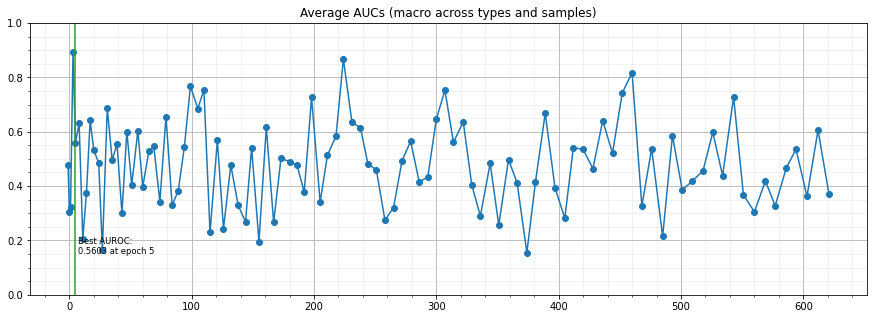

In [82]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.index.to_series(), df, marker="o")
ax.axvline(best_epoch, color="tab:green")
ax.set_ylim(0,1)

n_epochs = df.index.max() + 1
x_text = best_epoch + (2 if best_epoch < n_epochs * 0.75 else -2)
ha_text = "left" if best_epoch < n_epochs * 0.75 else "right"

ax.grid(which="major")
ax.minorticks_on()
ax.grid(which="minor", alpha=0.2)
ax.text(
    x=x_text,
    y=0.15,
    s=f"Best AUROC:\n{df.loc[best_epoch]:.4f} at epoch {best_epoch}",
    ha=ha_text,
    size="small",
)
ax.set_title("Average AUCs (macro across types and samples)")

In [2]:
MODEL_NAME = "ADDA"
DSET = "dlpfc"
SC_ID = "GSE144136"
ST_ID = "spatialLIBD"

CONFIGS_DIR = "configs"



In [3]:
def get_best_params_file(model_name, dset, sc_id, st_id, configs_dir="configs"):
    pattern = os.path.join("model", model_name, dset, f"{sc_id}_{st_id}", "**", "reverse_val_best_epoch.csv")

    results = []
    for rv_result_path in glob.glob(pattern, recursive=True):
        results.append(pd.read_csv(rv_result_path, index_col=0))

    results_df = pd.concat(results, axis=0)
    best_hp = results_df["val"].idxmin()
    config_fname = results_df.loc[best_hp, "config_fname"]
    with open(os.path.join(configs_dir, model_name, config_fname), "r") as f:
        config = yaml.safe_load(f)

    lib_params = config["lib_params"]
    data_params = config["data_params"]
    model_params = config["model_params"]


    torch_seed = lib_params.get("manual_seed")
    lib_seed_path = str(torch_seed) if "manual_seed" in lib_params else "random"

    model_folder = data_loading.get_model_rel_path(
        model_name,
        model_params["model_version"],
        lib_seed_path=lib_seed_path,
        **data_params,
    )

    model_folder

    model_path = os.path.join("model", model_folder, "advtrain", "samp_split" if data_params.get("samp_split") else "", "final_model.pth")
    checkpoint = torch.load(model_path)

    try:
        epoch = checkpoint["epoch"]
    except KeyError:
        epoch = checkpoint.get("iters")

    if int(epoch) != int(results_df.loc[best_hp, "best_epoch"]):
        raise ValueError("Epoch mismatch")
    
    return config_fname, results_df

get_best_params_file(MODEL_NAME, DSET, SC_ID, ST_ID, CONFIGS_DIR)

'standard_bnfix_adam_beta1_5_samp_split.yml'

{'model': ADDAST(
   (source_encoder): MLP(
     (encoder): Sequential(
       (0): Linear(in_features=360, out_features=1024, bias=True)
       (1): BatchNorm1d(1024, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
       (2): LeakyReLU(negative_slope=0.01)
       (3): Dropout(p=0.5, inplace=False)
       (4): Linear(in_features=1024, out_features=512, bias=True)
       (5): BatchNorm1d(512, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
       (6): LeakyReLU(negative_slope=0.01)
       (7): Dropout(p=0.5, inplace=False)
       (8): Linear(in_features=512, out_features=64, bias=True)
       (9): ELU(alpha=1.0)
     )
   )
   (clf): MLP(
     (encoder): Sequential(
       (0): Linear(in_features=64, out_features=33, bias=True)
       (1): LogSoftmax(dim=1)
     )
   )
   (target_encoder): MLP(
     (encoder): Sequential(
       (0): Linear(in_features=360, out_features=1024, bias=True)
       (1): BatchNorm1d(1024, eps=0.001, momentum=0.01, affine=Tru

In [3]:
selected_dir = get_selected_dir(
    dset_dir=get_dset_dir("data", dset="mouse_cortex"),
    sc_id="GSE115746",
    st_id="spotless_mouse_cortex",
    n_markers=20,
    all_genes=False,

)
sp_d = load_spatial(selected_dir, scaler_name="standard", st_split=False, samp_split=True)

In [2]:
adata_st = sc.read_h5ad("data/dlpfc/preprocessed/GSE144136_spatialLIBD/20markers/unscaled/mat_sp_samp_split_d.h5ad")

In [4]:
(
            adata_st[adata_st.obs["split"] == split].X.to_array() for split in data_loading.SPLITS
        )

,split,sample_id,X,Y,index,key,subject,replicate,Cluster,sum_umi,sum_gene,cell_count,in_tissue,spatialLIBD,array_col,array_row
spot,,,,,,,,,,,,,,,,
AAACAACGAATAGTTC-1,train,151507,3276,2514,AAACAACGAATAGTTC-1,151507_AAACAACGAATAGTTC-1,Br5292,1,6,948,727,0,True,L1,16,0
AAACAAGTATCTCCCA-1,train,151507,9178,8520,AAACAAGTATCTCCCA-1,151507_AAACAAGTATCTCCCA-1,Br5292,1,3,4261,2170,3,True,L3,102,50
AAACAATCTACTAGCA-1,train,151507,5133,2878,AAACAATCTACTAGCA-1,151507_AAACAATCTACTAGCA-1,Br5292,1,2,1969,1093,2,True,L1,43,3
AAACACCAATAACTGC-1,train,151507,3462,9581,AAACACCAATAACTGC-1,151507_AAACACCAATAACTGC-1,Br5292,1,5,3368,1896,5,True,WM,19,59
AAACAGCTTTCAGAAG-1,train,151507,2779,7663,AAACAGCTTTCAGAAG-1,151507_AAACAGCTTTCAGAAG-1,Br5292,1,1,2981,1620,3,True,L6,9,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1-9,test,151674,5595,9461,TTGTTTCACATCCAGG-1.9,151674_TTGTTTCACATCCAGG-1,Br8100,2,2,4802,2425,5,True,WM,42,58
TTGTTTCATTAGTCTA-1-9,test,151674,4767,9694,TTGTTTCATTAGTCTA-1.9,151674_TTGTTTCATTAGTCTA-1,Br8100,2,2,4800,2489,6,True,WM,30,60
TTGTTTCCATACAACT-1-9,test,151674,4574,7896,TTGTTTCCATACAACT-1.9,151674_TTGTTTCCATACAACT-1,Br8100,2,1,1209,832,4,True,L6,27,45


In [20]:
adata_st_d = {}
for sid in adata_st.obs["sample_id"].unique():
    adata_st_d[sid] = adata_st[adata_st.obs["sample_id"] == sid]
    adata_st_d[sid].obs.drop(columns=["sample_id"], inplace=True)
adata_col = ad.concat(adata_st_d, label="sample_id")

In [27]:
x_st_train, x_st_val = model_selection.train_test_split(
                    adata_col, test_size=0.2, random_state=5
                )

In [29]:
x_st_train.obs

,X,Y,nCount_RNA,nFeature_RNA,orig.ident,sample_id
spot_7-4,1533.980583,466.019417,60354.0,9732,0,Eng2019_cortex_svz_fov4
spot_7-6,1533.980583,466.019417,18300.0,6374,0,Eng2019_cortex_svz_fov6
spot_6-6,1000.000000,1533.980583,5715.0,3176,0,Eng2019_cortex_svz_fov6
spot_7-5,1533.980583,466.019417,20200.0,6750,0,Eng2019_cortex_svz_fov5
spot_9-1,1533.980583,1533.980583,60364.0,9696,0,Eng2019_cortex_svz_fov1
spot_6-2,1000.000000,1533.980583,53940.0,9530,0,Eng2019_cortex_svz_fov2
spot_7,1533.980583,466.019417,35974.0,8725,0,Eng2019_cortex_svz_fov0
spot_7-2,1533.980583,466.019417,43486.0,9049,0,Eng2019_cortex_svz_fov2
spot_3,466.019417,1533.980583,15919.0,6288,0,Eng2019_cortex_svz_fov0
spot_2-2,466.019417,1000.000000,47721.0,9180,0,Eng2019_cortex_svz_fov2


In [15]:
adata = sc.read_h5ad("data/mouse_cortex/sc_adata/GSE115746.h5ad")



KeyError: 'sample_id'

In [3]:
adata.obs["cell_type"].value_counts()

L5 IT                           2964
Vip                             2679
Sst                             2551
L6 IT                           2173
Pvalb                           2076
Lamp5                           1843
L4                              1352
L6 CT                           1225
L2/3 IT                         1178
L5 PT                            901
NP                               740
Astro                            556
L6b                              473
Sncg                             249
High Intronic                    182
Endo                             166
VLMC                             133
Batch Grouping                   132
Macrophage                       131
Oligo                            131
SMC                              109
Serpinf1                          85
Meis2                             55
Doublet Endo                      41
Doublet VISp L5 NP and L6 CT      35
Peri                              32
CR                                17
D

In [29]:
cell_subclass_to_spot_composition = {
    "Astro": {"Astrocytes deep", "Astrocytes superficial"},
    "CR": set(),
    "Batch Grouping": {"Excitatory layer 5/6"}, # all cell clusters are L5
    "L2/3 IT": {"Excitatory layer II", "Excitatory layer 3"},
    "L4" : {"Excitatory layer 4"},
    "L5 PT": {"Excitatory layer 5/6"},
    "L5 IT": {"Excitatory layer 5/6"},
    'L6 CT': {"Excitatory layer 5/6"},
    'L6 IT': {"Excitatory layer 5/6"},
    'L6b': {"Excitatory layer 5/6"},
    'NP': {"Excitatory layer 5/6"}, # all NP are L5 or L6
    "Endo": {"Endothelial", "Choroid plexus"},
    'High Intronic': {"Excitatory layer 5/6"}, # all High Intronic are VISp L5 Endou
    ## Doublets; these are cell clusters



    "Peri": {"Endothelial","Choroid plexus"},
    "SMC": {"Endothelial","Choroid plexus"},
    "VLMC": {"Endothelial","Choroid plexus"},

    "Macrophage": {"Microglia"},

    "Lamp5": {"Interneurons, Interneurons deep"}, # "We define six subclasses of GABAergic cells: Sst, Pvalb, Vip, Lamp5, Sncg and Serpinf1, and two distinct types: Sst–Chodl and Meis2–Adamts19 (Fig. 1c). We represent the taxonomy by constellation diagrams, dendrograms, layer-of-isolation, and the expression of select marker genes (Fig. 5a–f). The major division among GABAergic types largely corresponds to their developmental origin in the medial ganglionic eminence (Pvalb and Sst subclasses) or caudal ganglionic eminence (Lamp5, Sncg, Serpinf1 and Vip subclasses)."
    "Meis2": {"Interneurons, Interneurons deep"},
    "Pvalb": {"Interneurons, Interneurons deep"},
    "Serpinf1": {"Interneurons, Interneurons deep"},
    "Sncg": {"Interneurons, Interneurons deep"},
    "Sst": {"Interneurons, Interneurons deep"},
    "Vip": {"Interneurons, Interneurons deep"},

    

      "Low Quality" : None,
    'No Class': None,  
}

cell_cluster_cell_type_to_spot_composition = {
        "Doublet VISp L5 NP and L6 CT": {"Excitatory layer 5/6"},
    "Doublet Endo and Peri_1": {"Endothelial", "Choroid plexus"}, # no choroid plexus in other dataset
    "Doublet Astro Aqp4 Ex": {"Astrocytes deep", "Astrocytes superficial"},
    "Doublet SMC and Glutamatergic": {"Endothelial", "Choroid plexus"},
    "Doublet Endo Peri SMC": {"Endothelial", "Choroid plexus"},
    "Oligo Serpinb1a": {"Oligodendrocytes"},
    "Oligo Synpr": {"Oligodendrocytes"},
    "Oligo Rassf10": {"Oligodendrocytes"},
    "OPC Pdgfra Grm": {"OPC"},
    "OPC Pdgfra Ccnb1": {"OPC"},
}

{'Astro': {'Astrocytes deep', 'Astrocytes superficial'},
 'CR': set(),
 'Batch Grouping': {'Excitatory layer 5/6'},
 'L2/3 IT': {'Excitatory layer 3', 'Excitatory layer II'},
 'L4': {'Excitatory layer 4'},
 'L5 PT': {'Excitatory layer 5/6'},
 'L5 IT': {'Excitatory layer 5/6'},
 'L6 CT': {'Excitatory layer 5/6'},
 'L6 IT': {'Excitatory layer 5/6'},
 'L6b': {'Excitatory layer 5/6'},
 'NP': {'Excitatory layer 5/6'},
 'Endo': {'Endothelial'},
 'High Intronic': {'Excitatory layer 5/6'},
 'Doublet VISp L5 NP and L6 CT': {'Excitatory layer 5/6'},
 'Doublet Endo and Peri_1': {'Choroid plexus', 'Endothelial'},
 'Doublet Astro Aqp4 Ex': {'Astrocytes deep', 'Astrocytes superficial'},
 'Doublet SMC and Glutamatergic': {'Choroid plexus'},
 'Doublet Endo Peri SMC': {'Choroid plexus', 'Endothelial'},
 'Oligo Serpinb1a': {'Oligodendrocytes'},
 'Oligo Synpr': {'Oligodendrocytes'},
 'Oligo Rassf10': {'Oligodendrocytes'},
 'OPC Pdgfra Grm': {'OPC'},
 'OPC Pdgfra Ccnb1': {'OPC'},
 'Peri': {'Choroid plexus

In [28]:
adata.obs["cell_cluster"][adata.obs["cell_subclass"] == "VLMC"].value_counts().head(20)

VLMC Osr1 Mc5r        76
VLMC Spp1 Col15a1     39
VLMC Osr1 Cd74        12
VLMC Spp1 Hs3st6       6
Sncg Vip Itih5         0
Sncg Slc17a8           0
Pvalb Calb1 Sst        0
Sncg Vip Nptx2         0
Pvalb Gabrg1           0
Pvalb Gpr149 Islr      0
Pvalb Reln Itm2a       0
Pvalb Reln Tac1        0
Pvalb Sema3e Kank4     0
Pvalb Th Sst           0
Pvalb Akr1c18 Ntf3     0
Pvalb Vipr2            0
SMC Acta2              0
Serpinf1 Aqp5 Vip      0
Serpinf1 Clrn1         0
Sncg Gpr50             0
Name: cell_cluster, dtype: int64

In [7]:
adata.obs["cell_cluster"].unique()

[NaN, 'Pvalb Tpbg', 'L4 IT VISp Rspo1', 'Vip Chat Htr1f', 'L2/3 IT VISp Agmat', ..., 'Batch Grouping VISp L5 PT Ctxn3', 'Batch Grouping VISp L5 PT Chrna6', 'Low Quality VISp L5 PT Ctxn3 2', 'L6b ALM Olfr111 Nxph1', 'L6b ALM Olfr111 Spon1']
Length: 152
Categories (151, object): ['Astro Aqp4', 'Batch Grouping VISp L5 PT Chrna6', 'Batch Grouping VISp L5 PT Ctxn3', 'CR Lhx5', ..., 'Vip Ptprt Pkp2', 'Vip Pygm C1ql1', 'Vip Rspo1 Itga4', 'Vip Rspo4 Rxfp1 Chat']

In [8]:
adata.obs

,title,source_name,organism,donor_id,donor_sex,donor_genotype,injection_type,injection_target,injected_material,dissected_region,...,cell_cluster,molecule,SRA_Run,GEO_Sample,GEO_Sample_Title,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
F2S4_150422_002_A01,F2S4_150422_002_A01,Primary Visual Cortex (VISp),Mus musculus,184756,M,Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,NaN,polyA RNA,SRR8322796,GSM3189947,VISp_Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt_No Injec...,12141,12141,1204630.0,0.0,0.0
F2S4_150422_002_B01,F2S4_150422_002_B01,Primary Visual Cortex (VISp),Mus musculus,184756,M,Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,NaN,polyA RNA,SRR8322851,GSM3189947,VISp_Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt_No Injec...,11760,11760,1259862.0,0.0,0.0
F2S4_150422_002_C01,F2S4_150422_002_C01,Primary Visual Cortex (VISp),Mus musculus,184756,M,Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,NaN,polyA RNA,SRR8322862,GSM3189947,VISp_Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt_No Injec...,10079,10079,1128827.0,0.0,0.0
F2S4_150422_002_D01,F2S4_150422_002_D01,Primary Visual Cortex (VISp),Mus musculus,184756,M,Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,NaN,polyA RNA,SRR8322873,GSM3189947,VISp_Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt_No Injec...,10570,10570,879874.0,0.0,0.0
F2S4_150422_002_E01,F2S4_150422_002_E01,Primary Visual Cortex (VISp),Mus musculus,184756,M,Rbp4-Cre_KL100/wt;Ai14(RCL-tdT)/wt,No Injection,No Injection,No Injection,VISp,...,NaN,polyA RNA,SRR8322884,GSM3189947,VISp_Rbp4-Cre_KL1/wt;Ai14(RCL-tdT)/wt_No Injec...,9737,9737,1117094.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F1S4_180124_317_D01,F1S4_180124_317_D01,Anterior Lateral Motor Cortex (ALM),Mus musculus,364992,F,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,No Injection,No Injection,No Injection,ALM,...,Lamp5 Lsp1,polyA RNA,SRR7315188,GSM3189867,ALM_Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt_No Injection_1,8601,8601,1022536.0,0.0,0.0
F1S4_180124_317_E01,F1S4_180124_317_E01,Anterior Lateral Motor Cortex (ALM),Mus musculus,364992,F,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,No Injection,No Injection,No Injection,ALM,...,Sncg Slc17a8,polyA RNA,SRR7315189,GSM3189867,ALM_Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt_No Injection_1,9822,9822,724678.0,0.0,0.0
F1S4_180124_317_F01,F1S4_180124_317_F01,Anterior Lateral Motor Cortex (ALM),Mus musculus,364992,F,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,No Injection,No Injection,No Injection,ALM,...,Sst Hpse Sema3c,polyA RNA,SRR7315190,GSM3189867,ALM_Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt_No Injection_1,8729,8729,980847.0,0.0,0.0
F1S4_180124_317_G01,F1S4_180124_317_G01,Anterior Lateral Motor Cortex (ALM),Mus musculus,364992,F,Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt,No Injection,No Injection,No Injection,ALM,...,Sncg Slc17a8,polyA RNA,SRR7315191,GSM3189867,ALM_Rasgrf2-T2A-dgFlpO/wt;Ai65F/wt_No Injection_1,10632,10632,1029765.0,0.0,0.0


In [9]:
adata_st = sc.read_h5ad("data/mouse_cortex/st_adata/spotless_mouse_cortex-Eng2019_cortex_svz_fov0.h5ad")


In [11]:
adata_st.obsm["relative_spot_composition"]

,Astrocytes.deep,Astrocytes.superficial,Choroid.plexus,Endothelial,Ependymal,Excitatory.layer.3,Excitatory.layer.4,Excitatory.layer.5.6,Excitatory.layer.II,Interneurons,Interneurons.deep,Microglia,NSC,Neural.progenitors,Neuroblasts,OPC,Oligodendrocytes
spot_1,0.000000,0.000000,0.0,0.058824,0.0,0.176471,0.235294,0.0,0.352941,0.117647,0.000000,0.058824,0.0,0.0,0.0,0.000000,0.0
spot_2,0.076923,0.076923,0.0,0.000000,0.0,0.076923,0.153846,0.0,0.461538,0.076923,0.000000,0.076923,0.0,0.0,0.0,0.000000,0.0
spot_3,0.000000,0.333333,0.0,0.166667,0.0,0.000000,0.000000,0.0,0.166667,0.166667,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0
spot_4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.571429,0.285714,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
spot_5,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.636364,0.181818,0.000000,0.000000,0.0,0.0,0.0,0.181818,0.0
spot_6,0.000000,0.800000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.0,0.0,0.0,0.000000,0.0
spot_7,0.000000,0.000000,0.0,0.000000,0.0,0.222222,0.222222,0.0,0.333333,0.111111,0.000000,0.111111,0.0,0.0,0.0,0.000000,0.0
spot_8,0.000000,0.000000,0.0,0.083333,0.0,0.000000,0.083333,0.0,0.583333,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
spot_9,0.000000,0.000000,0.0,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.0


In [12]:
adata_st.obsm["relative_spot_composition"]["Choroid.plexus"].sum()

0.0

In [17]:
adata_sc = sc.read_h5ad("data/mouse_cortex/sc_adata/spotless_mouse_cortex.h5ad")
adata_sc.obs["cell_subclass"].cat.categories

Index(['Astrocytes deep', 'Astrocytes superficial', 'Choroid plexus',
       'Endothelial', 'Ependymal', 'Excitatory layer 3', 'Excitatory layer 4',
       'Excitatory layer 5/6', 'Excitatory layer II', 'Interneurons',
       'Interneurons deep', 'Microglia', 'NSC', 'Neural progenitors',
       'Neuroblasts', 'OPC', 'Oligodendrocytes'],
      dtype='object')

In [2]:
SPOTLESS_DIR = "data/spotless/standards"

CORTEX_DIR = "data/mouse_cortex"
OLFACTORY_DIR = "data/mouse_olfactory"
# SC_ID_OLFACTORY = "spotless_mouse_olfactory"
# SC_ID_CORTEX = "spotless_mouse_cortex"
# SC_ID_VISUAL = "spotless_mouse_visual"


# %%

standard_to_id = {
    "gold_standard_1": "spotless_mouse_cortex",
    "gold_standard_2": "spotless_mouse_olfactory",
    "gold_standard_3": "spotless_mouse_visual",
    "gold_standard_3_12celltypes": "spotless_mouse_visual",
}

id_to_dir = {
    "spotless_mouse_cortex": CORTEX_DIR,
    "spotless_mouse_olfactory": OLFACTORY_DIR,
    "spotless_mouse_visual": CORTEX_DIR,
}



In [45]:
def cat_to_obsm(cat, adata, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    selected_cols = adata.obs.columns.to_series().map(lambda x: x.split(".")[0] == cat)
    adata.obsm[cat] = (
        adata.obs.loc[:, selected_cols]
        .rename(columns=lambda x: x[len(cat + ".") :])
        .drop(columns=drop_cols)
    )
    keep_cols = ~selected_cols
    # print(keep_cols)

    for drop_col in drop_cols:
        keep_cols[cat + "." + drop_col] = True
    adata.obs = adata.obs.loc[:, keep_cols]

fpaths = sorted(glob.glob(os.path.join(SPOTLESS_DIR, "gold_standard_1", "*.h5ad")))
sample_ids = [os.path.basename(f).split(".")[0] for f in fpaths]
fovs = [sc.read_h5ad(name) for name in fpaths]

obs_cols = sorted(list(set.union(*[set(fov.obs.columns) for fov in fovs])))
for fov, sample_id in zip(fovs, sample_ids):
    fov.obs = fov.obs.reindex(columns=obs_cols)
    fov.obs = fov.obs.fillna(0)
    fov.obs = fov.obs.rename(columns={"coordinates.x": "X", "coordinates.y": "Y"})
    fov.X = csr_matrix(fov.X.astype("float32"))
    fov.raw = fov

    fov.obs = fov.obs.loc[:,~fov.obs.columns.str.contains("spot_no")]

    cat_to_obsm("relative_spot_composition", fov)
    cat_to_obsm("spot_composition", fov)

In [49]:
fovs[0].obsm["relative_spot_composition"]

,Astrocytes.deep,Astrocytes.superficial,Choroid.plexus,Endothelial,Ependymal,Excitatory.layer.3,Excitatory.layer.4,Excitatory.layer.5.6,Excitatory.layer.II,Interneurons,Interneurons.deep,Microglia,NSC,Neural.progenitors,Neuroblasts,OPC,Oligodendrocytes
spot_1,0.000000,0.000000,0.0,0.058824,0.0,0.176471,0.235294,0.0,0.352941,0.117647,0.000000,0.058824,0.0,0.0,0.0,0.000000,0.0
spot_2,0.076923,0.076923,0.0,0.000000,0.0,0.076923,0.153846,0.0,0.461538,0.076923,0.000000,0.076923,0.0,0.0,0.0,0.000000,0.0
spot_3,0.000000,0.333333,0.0,0.166667,0.0,0.000000,0.000000,0.0,0.166667,0.166667,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0
spot_4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.571429,0.285714,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
spot_5,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.636364,0.181818,0.000000,0.000000,0.0,0.0,0.0,0.181818,0.0
spot_6,0.000000,0.800000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.0,0.0,0.0,0.000000,0.0
spot_7,0.000000,0.000000,0.0,0.000000,0.0,0.222222,0.222222,0.0,0.333333,0.111111,0.000000,0.111111,0.0,0.0,0.0,0.000000,0.0
spot_8,0.000000,0.000000,0.0,0.083333,0.0,0.000000,0.083333,0.0,0.583333,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
spot_9,0.000000,0.000000,0.0,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.0


In [55]:
for ref_path in glob.glob(os.path.join(SPOTLESS_DIR, "reference", "gold_standard_1.h5ad")):
    if "19celltypes" in ref_path:
        continue

    name = os.path.basename(ref_path).split(".")[0]
    id = standard_to_id[name]

    dset_dir = id_to_dir[id]
    print(f"Processing {name} to {id} in {dset_dir}")

    sc_dir = os.path.join(dset_dir, "sc_adata")
    if not os.path.exists(sc_dir):
        os.makedirs(sc_dir)

    adata_sc = sc.read_h5ad(ref_path)

    qc_sc(adata_sc)

    adata_sc.obs = adata_sc.obs.rename(columns={"celltype": "cell_subclass"})

    adata_sc.X = csr_matrix(adata_sc.X.astype("float32"))
    adata_sc.raw = adata_sc

    break

    # adata_sc.write(os.path.join(sc_dir, f"{id}.h5ad"))


Processing gold_standard_1 to spotless_mouse_cortex in data/mouse_cortex
0 mitochondrial genes


In [59]:
import re



{'Excitatory.layer.3': 'Excitatory layer 3',
 'Excitatory.layer.II': 'Excitatory layer II',
 'Interneurons': 'Interneurons',
 'Excitatory.layer.4': 'Excitatory layer 4',
 'Microglia': 'Microglia',
 'Astrocytes.deep': 'Astrocytes deep',
 'Endothelial': 'Endothelial',
 'Interneurons.deep': 'Interneurons deep',
 'Astrocytes.superficial': 'Astrocytes superficial',
 'OPC': 'OPC',
 'Excitatory.layer.5.6': 'Excitatory layer 5/6',
 'Neuroblasts': 'Neuroblasts',
 'NSC': 'NSC',
 'Oligodendrocytes': 'Oligodendrocytes',
 'Ependymal': 'Ependymal',
 'Neural.progenitors': 'Neural progenitors',
 'Choroid.plexus': 'Choroid plexus'}

In [69]:
adata = sc.read_h5ad("data/mouse_cortex/sc_adata/spotless_mouse_cortex.h5ad")

In [70]:
adata.X.toarray().max()

150.0

In [71]:
adata.raw.X.toarray().max()

150.0

In [5]:
for fov in fovs:
    fov.obs = fov.obs.reindex(columns=obs_cols)

In [6]:
# for column in fovs[0].obs.columns:
#     display(fovs[0].obs[column])
[os.path.basename(f).split(".")[0] for f in fpaths]

['Eng2019_cortex_svz_fov0',
 'Eng2019_cortex_svz_fov1',
 'Eng2019_cortex_svz_fov2',
 'Eng2019_cortex_svz_fov3',
 'Eng2019_cortex_svz_fov4',
 'Eng2019_cortex_svz_fov5',
 'Eng2019_cortex_svz_fov6']

In [12]:
gs1_ref_path = "data/spotless/reference/gold_standard_1.h5ad"

In [13]:
gs1_ref = sc.read_h5ad(gs1_ref_path)

In [14]:
gs1_ref

AnnData object with n_obs × n_vars = 906 × 10000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'louvain', 'celltype', 'Field.of.View', 'X', 'Y', 'celltype_coarse', 'Region'
    var: 'features'

In [6]:
# adata.obs

In [11]:
# result = pyreadr.read_r('data/spotless/gold_standard_1/Eng2019_cortex_svz_fov0.rds')
with h5py.File("data/spotless/gold_standard_1.h5" , "r") as f:
    for name in f:
        gene_names = [str(gene, "utf-8") for gene in f[name]["geneNames"][()]]
        ad.AnnData(csr_matrix(f[name]["counts"][()]), dtype=np.int64)

AnnData object with n_obs × n_vars = 9 × 10000
AnnData object with n_obs × n_vars = 9 × 10000
AnnData object with n_obs × n_vars = 9 × 10000
AnnData object with n_obs × n_vars = 9 × 10000
AnnData object with n_obs × n_vars = 9 × 10000
AnnData object with n_obs × n_vars = 9 × 10000
AnnData object with n_obs × n_vars = 9 × 10000


In [1]:
import numpy as np

rng = np.random.default_rng()
X = rng.standard_normal(1000)

In [9]:
def standard(x):
    return np.exp(-np.power(x, 2.)/2) /np.sqrt(2*np.pi)

In [10]:
p = standard(X)

In [11]:
2**(-(p * np.log2(p)).sum())

1.5112405659839928e+144

In [1]:
import os
import glob

In [2]:
for name in glob.iglob("/lustre07/scratch/williamm/AGrEDA/model/*.pth"):
    print(name)
    os.remove(name)
print("done")

done


In [3]:
os.getcwd()


'/lustre07/scratch/williamm/AGrEDA'

In [4]:
import tarfile

In [10]:
with tarfile.open("./TMP/dum.tar.gz", "w:gz") as tar:
    for name in glob.glob("./TMP/*.dum"):
        tar.add(name, arcname=os.path.basename(name))

In [11]:
with tarfile.open("./TMP/dum.tar.gz", "r:gz") as tar:
    tar.extractall("./TMP")

In [12]:
for name in glob.iglob("/lustre07/scratch/williamm/AGrEDA/*"):
    print(name)

/lustre07/scratch/williamm/AGrEDA/autoenc_allgenes.ipynb
/lustre07/scratch/williamm/AGrEDA/wheels
/lustre07/scratch/williamm/AGrEDA/autosubmitter.py
/lustre07/scratch/williamm/AGrEDA/requirements_simple.txt
/lustre07/scratch/williamm/AGrEDA/autoenc_st.ipynb
/lustre07/scratch/williamm/AGrEDA/hello.out
/lustre07/scratch/williamm/AGrEDA/requirements_cc.txt
/lustre07/scratch/williamm/AGrEDA/prep_data.py
/lustre07/scratch/williamm/AGrEDA/adda.py
/lustre07/scratch/williamm/AGrEDA/coral.py
/lustre07/scratch/williamm/AGrEDA/AGrEDA-p_def.code-workspace
/lustre07/scratch/williamm/AGrEDA/eda-pdac-chijimatsu.ipynb
/lustre07/scratch/williamm/AGrEDA/environment.yml
/lustre07/scratch/williamm/AGrEDA/results
/lustre07/scratch/williamm/AGrEDA/run_jupyterlab.sh
/lustre07/scratch/williamm/AGrEDA/model
/lustre07/scratch/williamm/AGrEDA/scratch.ipynb
/lustre07/scratch/williamm/AGrEDA/batch_scripts
/lustre07/scratch/williamm/AGrEDA/reproduce_celldart.py
/lustre07/scratch/williamm/AGrEDA/eval_config.py
/lust

In [2]:
adata = sc.read_h5ad("data/dlpfc/preprocessed/GSE144136_spatialLIBD/20markers/sc_train.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 28169 × 360
    obs: 'patient', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type', 'lab_sc_num'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'rank_genes_groups'

In [13]:
with h5py.File("data/dlpfc/preprocessed/GSE144136_spatialLIBD/20markers/minmax/sc_8mix.hdf5", "r") as f:
    print(f.keys())
    labs = f["y/train"][()]


<KeysViewHDF5 ['X', 'y']>


In [38]:
with open("data/dlpfc/preprocessed/GSE144136_spatialLIBD/20markers/sc_sub_dict.pkl", "rb") as f:
    sc_sub_dict = pickle.load(f)
sc_sub_dict

{0: 'Astros_1',
 1: 'Astros_2',
 2: 'Astros_3',
 3: 'Endo',
 4: 'Ex_1_L5_6',
 5: 'Ex_2_L5',
 6: 'Ex_3_L4_5',
 7: 'Ex_4_L_6',
 8: 'Ex_5_L5',
 9: 'Ex_6_L4_6',
 10: 'Ex_7_L4_6',
 11: 'Ex_8_L5_6',
 12: 'Ex_9_L5_6',
 13: 'Ex_10_L2_4',
 14: 'Inhib_1',
 15: 'Inhib_2_VIP',
 16: 'Inhib_3_SST',
 17: 'Inhib_4_SST',
 18: 'Inhib_5',
 19: 'Inhib_6_SST',
 20: 'Inhib_7_PVALB',
 21: 'Inhib_8_PVALB',
 22: 'Micro/Macro',
 23: 'Mix_1',
 24: 'Mix_2',
 25: 'Mix_3',
 26: 'Mix_4',
 27: 'Mix_5',
 28: 'OPCs_1',
 29: 'OPCs_2',
 30: 'Oligos_1',
 31: 'Oligos_2',
 32: 'Oligos_3'}

In [44]:
labs_df=pd.DataFrame(labs)
labs_df = labs_df.rename(columns=sc_sub_dict)
# labs_df = labs_df.stack().reset_index().rename({"level_0": "sample", "level_1": "cell_type", 0: "proportion"}, axis=1)
labs_df

,Astros_1,Astros_2,Astros_3,Endo,Ex_1_L5_6,Ex_2_L5,Ex_3_L4_5,Ex_4_L_6,Ex_5_L5,Ex_6_L4_6,...,Mix_1,Mix_2,Mix_3,Mix_4,Mix_5,OPCs_1,OPCs_2,Oligos_1,Oligos_2,Oligos_3
0,0.000000,0.165779,0.0,0.000000,0.0,0.000000,0.228490,0.106702,0.000000,0.066345,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.139908
1,0.156004,0.000000,0.0,0.000000,0.0,0.000000,0.071186,0.000000,0.000000,0.000000,...,0.0,0.013479,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,0.000000,0.137485,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.171952,0.120894,...,0.0,0.000000,0.0,0.124442,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.173720,0.000000,0.000000,0.488182,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.028696
4,0.000000,0.000000,0.0,0.147095,0.0,0.000000,0.093256,0.000000,0.000000,0.140062,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.119346,0.0,0.131546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.218413,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.109187,0.0,0.0,0.000000,0.0,0.000000
199996,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.272617,0.000000,0.060563,0.000000,...,0.0,0.000000,0.0,0.000000,0.160104,0.0,0.0,0.000000,0.0,0.457079
199997,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.330692,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.398703
199998,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.244830,0.000000,0.000000,0.096195,...,0.0,0.091596,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [45]:
labs_stds = labs_df.std(axis="columns")

In [50]:
labs_high_val = labs_df.agg(lambda col: col > 1/8 - labs_stds, axis=0)
labs_high_val

,Astros_1,Astros_2,Astros_3,Endo,Ex_1_L5_6,Ex_2_L5,Ex_3_L4_5,Ex_4_L_6,Ex_5_L5,Ex_6_L4_6,...,Mix_1,Mix_2,Mix_3,Mix_4,Mix_5,OPCs_1,OPCs_2,Oligos_1,Oligos_2,Oligos_3
0,False,True,False,False,False,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
199996,False,False,False,False,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,True
199997,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
199998,False,False,False,False,False,False,True,False,False,True,...,False,True,False,False,False,False,False,False,False,False


In [51]:
labs_high_val.sum(axis=1).mean()

5.62876